# 1. Import libraries

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Exploring Raw Data

In [38]:
df = pd.read_csv('weather_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88104 entries, 0 to 88103
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_epoch      88104 non-null  int64  
 1   time            88104 non-null  object 
 2   temp_c          88104 non-null  float64
 3   temp_f          88104 non-null  float64
 4   is_day          88104 non-null  int64  
 5   condition       88104 non-null  object 
 6   wind_mph        88104 non-null  float64
 7   wind_kph        88104 non-null  float64
 8   wind_degree     88104 non-null  int64  
 9   wind_dir        88104 non-null  object 
 10  pressure_mb     88104 non-null  int64  
 11  pressure_in     88104 non-null  float64
 12  precip_mm       88104 non-null  float64
 13  precip_in       88104 non-null  float64
 14  snow_cm         88104 non-null  float64
 15  humidity        88104 non-null  int64  
 16  cloud           88104 non-null  int64  
 17  feelslike_c     88104 non-null 

In [39]:
df.head()

,time_epoch,time,temp_c,temp_f,is_day,condition,wind_mph,wind_kph,wind_degree,wind_dir,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,city
0,1716397200,5/23/2024 0:00,25.8,78.5,0,Patchy rain possible,6.0,9.7,151,SSE,...,1,100,0,0,10.0,6,11.1,17.8,0,Hanoi
1,1716400800,5/23/2024 1:00,25.5,78.0,0,Moderate or heavy rain shower,4.9,7.9,151,SSE,...,1,100,0,0,9.0,5,9.5,15.3,0,Hanoi
2,1716404400,5/23/2024 2:00,25.6,78.1,0,Moderate or heavy rain shower,3.6,5.8,152,SSE,...,1,100,0,0,9.0,5,6.9,11.2,0,Hanoi
3,1716408000,5/23/2024 3:00,25.6,78.1,0,Cloudy,2.0,3.2,138,SE,...,0,0,0,0,9.0,5,6.3,10.1,0,Hanoi
4,1716411600,5/23/2024 4:00,25.4,77.8,0,Moderate rain at times,1.6,2.5,85,E,...,1,100,0,0,10.0,6,5.4,8.6,0,Hanoi


In [40]:
df.duplicated().sum()

np.int64(288)

Loại bỏ các dòng trùng lặp trước khi chia train/test để tránh Data Leakage

In [41]:
df.drop_duplicates(inplace=True)

In [42]:
class_counts = df['condition'].value_counts()
class_counts

condition
Clear                                  20499
Sunny                                  19936
Partly cloudy                          13291
Cloudy                                  9132
Patchy rain possible                    8982
Overcast                                8963
Moderate or heavy rain shower           3008
Moderate rain at times                  2049
Heavy rain at times                     1165
Light freezing rain                      352
Light rain shower                        122
Patchy moderate snow                      57
Moderate snow                             47
Thundery outbreaks possible               42
Light drizzle                             34
Light rain                                31
Fog                                       20
Moderate or heavy snow showers            18
Patchy light drizzle                      17
Mist                                      15
Moderate rain                             11
Freezing fog                               9


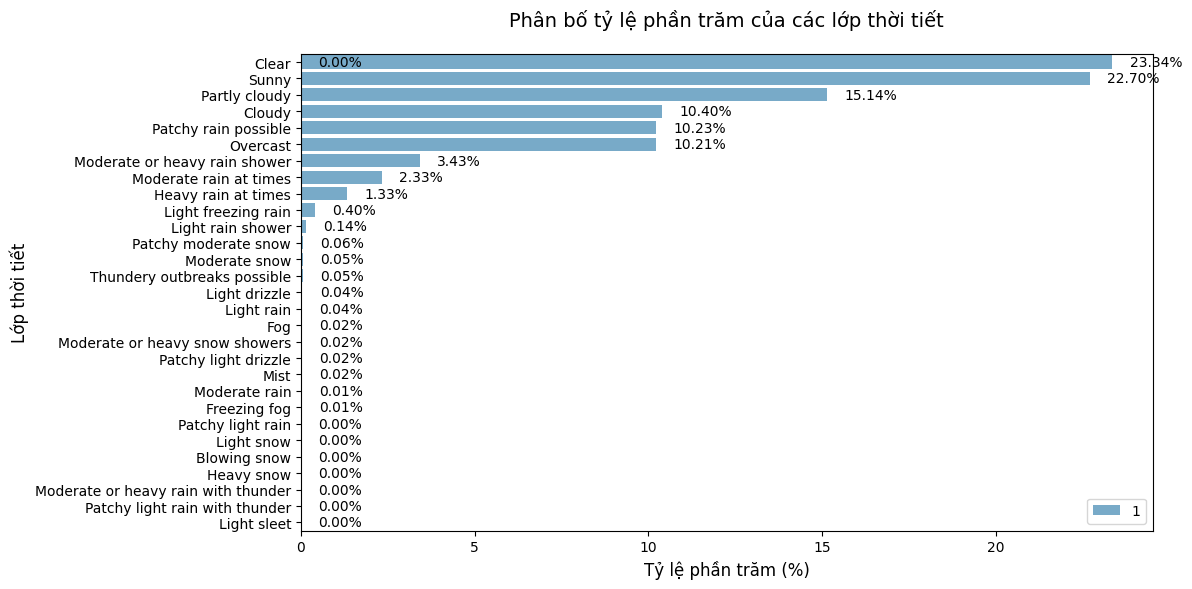

In [43]:
total_samples = len(df)

class_percentages = (class_counts / total_samples * 100)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_percentages.values, y=class_percentages.index, palette="Blues", hue=1)


for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             ha='left', va='center', fontsize=10, color='black')


plt.xlabel('Tỷ lệ phần trăm (%)', fontsize=12)
plt.ylabel('Lớp thời tiết', fontsize=12)
plt.title('Phân bố tỷ lệ phần trăm của các lớp thời tiết', fontsize=14, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()


plt.show()

# 3. Relabelling Data

In [44]:
import pandas as pd


condition_to_group = {
    # Ko nhóm
    'Clear': 'Clear',
    'Sunny': 'Sunny',
    'Partly cloudy': 'Partly cloudy',

    # Nhóm 1: Cloudy/Overcast
    'Cloudy': 'Cloudy/Overcast',
    'Overcast': 'Cloudy/Overcast',

    # Nhóm 3: Light Rain
    'Light rain': 'Light Rain',
    'Light rain shower': 'Light Rain',
    'Patchy light rain': 'Light Rain',

    # Drizzle
    'Light drizzle': 'Drizzle',
    'Patchy light drizzle': 'Drizzle',
    'Patchy rain possible': 'Drizzle',


    # Nhóm 4: Moderate/Heavy Rain
    'Moderate or heavy rain shower': 'Moderate/Heavy Rain',
    'Moderate rain at times': 'Moderate/Heavy Rain',
    'Heavy rain at times': 'Moderate/Heavy Rain',
    'Moderate rain': 'Moderate/Heavy Rain',

    # Nhóm 5: Snow
    'Patchy moderate snow': 'Snow',
    'Moderate snow': 'Snow',
    'Light snow': 'Snow',
    'Heavy snow': 'Snow',
    'Blowing snow': 'Snow',
    'Moderate or heavy snow showers': 'Snow',

    # Nhóm 6: Fog/Mist
    'Fog': 'Fog/Mist',
    'Mist': 'Fog/Mist',
    'Freezing fog': 'Fog/Mist',

    # Nhóm 7: Thunder
    'Patchy light rain with thunder': 'Thunder',
    'Moderate or heavy rain with thunder': 'Thunder',
    'Thundery outbreaks possible': 'Thunder',

    # Nhóm 8: Freezing rain
    'Light freezing rain': 'Freezing Rain',
    'Light sleet': 'Freezing Rain',
}


df['condition'] = df['condition'].map(condition_to_group)

print("Phân bố các nhóm thời tiết:\n", df['condition'].value_counts())

Phân bố các nhóm thời tiết:
 condition
Clear                  20499
Sunny                  19936
Cloudy/Overcast        18095
Partly cloudy          13291
Drizzle                 9033
Moderate/Heavy Rain     6233
Freezing Rain            353
Light Rain               157
Snow                     131
Thunder                   44
Fog/Mist                  44
Name: count, dtype: int64


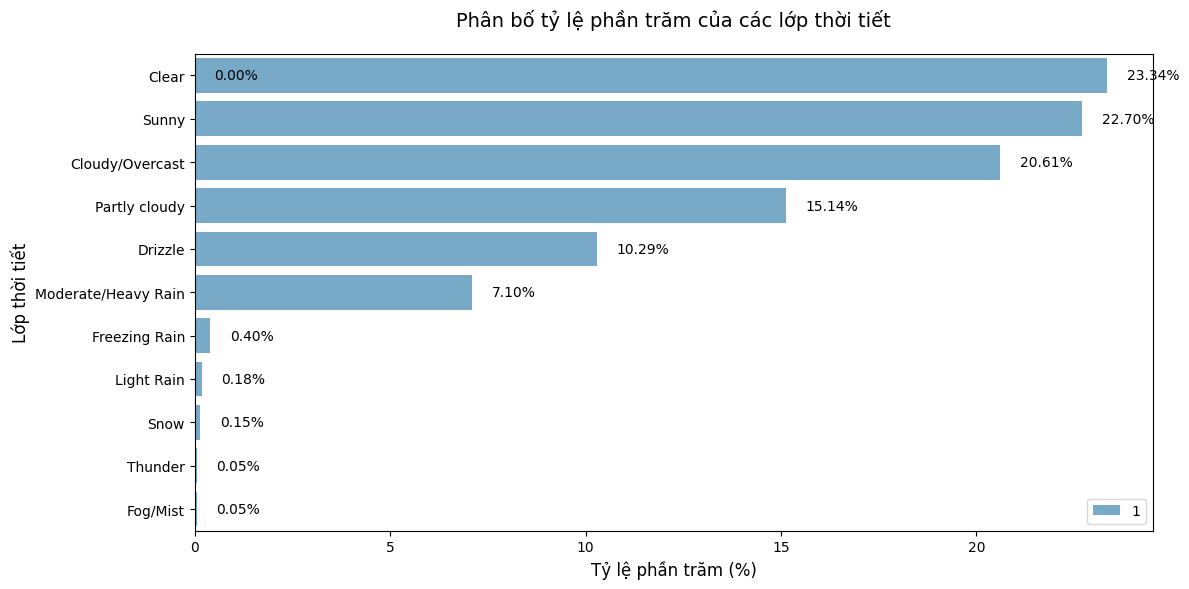

In [45]:
total_samples = len(df)

class_counts = df['condition'].value_counts()
class_percentages = (class_counts / total_samples * 100)

plt.figure(figsize=(12, 6))
bars = sns.barplot(x=class_percentages.values, y=class_percentages.index, palette="Blues", hue=1)


for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', 
             ha='left', va='center', fontsize=10, color='black')


plt.xlabel('Tỷ lệ phần trăm (%)', fontsize=12)
plt.ylabel('Lớp thời tiết', fontsize=12)
plt.title('Phân bố tỷ lệ phần trăm của các lớp thời tiết', fontsize=14, pad=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()


plt.show()

In [46]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['condition'])

print("\nPhân bố các nhóm thời tiết trong tập train:")  
print(train_df['condition'].value_counts())
print("\nPhân bố các nhóm thời tiết trong tập test:")
print(test_df['condition'].value_counts())


train_df.to_csv("./raw-data/raw_data_train.csv", index=False)
test_df.to_csv("./raw-data/raw_data_test.csv", index=False)


Phân bố các nhóm thời tiết trong tập train:
condition
Clear                  14349
Sunny                  13955
Cloudy/Overcast        12666
Partly cloudy           9304
Drizzle                 6323
Moderate/Heavy Rain     4363
Freezing Rain            247
Light Rain               110
Snow                      92
Fog/Mist                  31
Thunder                   31
Name: count, dtype: int64

Phân bố các nhóm thời tiết trong tập test:
condition
Clear                  6150
Sunny                  5981
Cloudy/Overcast        5429
Partly cloudy          3987
Drizzle                2710
Moderate/Heavy Rain    1870
Freezing Rain           106
Light Rain               47
Snow                     39
Thunder                  13
Fog/Mist                 13
Name: count, dtype: int64
